In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, ipdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

In [3]:
PATH = Path('data/pascal')
trn_j = json.load((PATH/'pascal_train2007.json').open())
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

In [4]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
    return trn_anno

trn_anno = get_trn_anno()

In [5]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [6]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

# Multiclass

In [7]:
MC_CSV = PATH/'tmp/mc.csv'

In [8]:
mc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]
mcs = [' '.join(str(p) for p in o) for o in mc]

In [9]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn','clas'])
df.to_csv(MC_CSV, index=False)

In [10]:
f_model=resnet34
bs=64
sz=224

In [11]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, tfms=tfms)

In [12]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      1.790039   5.455217   0.802569  



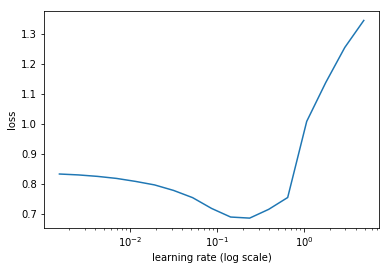

In [13]:
learn.lr_find(1e-5, 100)
learn.sched.plot()

In [14]:
lr = 2e-2

In [15]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32, 5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.324195   0.133326   0.955476  
    1      0.173333   0.078176   0.97331                   
    2      0.116622   0.07537    0.974429                  



[0.07536985, 0.9744290858507156]

In [16]:
lrs = np.array([lr/100, lr/10, lr])

In [18]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:11<00:02,  2.31it/s, loss=0.416] 

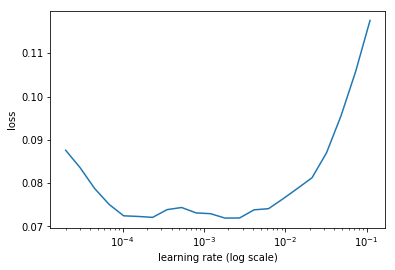

In [19]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [26]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32, 5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.021704   0.091689   0.971845  
    1      0.025243   0.096327   0.971342                   
    2      0.023048   0.087601   0.973655                   
    3      0.017873   0.088272   0.973723                   
    4      0.01297    0.089219   0.972844                   



[0.089219086, 0.9728440567851067]

In [27]:
y = learn.predict()
x, y = next(iter(md.val_dl))
x = to_np(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


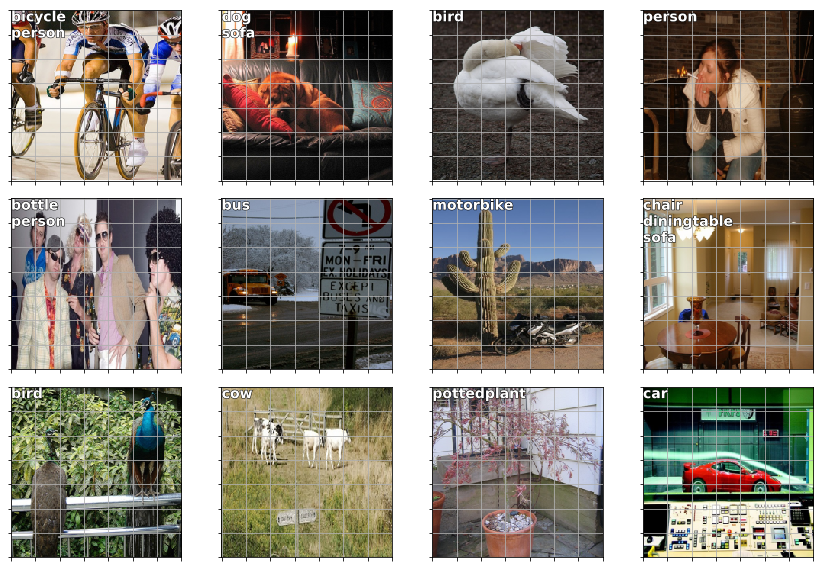

In [38]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i]>0.4)
    b = '\n'.join(md.classes[int(o)] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

# BBOX per cell

In [46]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

f_model=resnet34
sz=224
bs=64

In [40]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc]); mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [41]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [42]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn','bbox'])
df.to_csv(MBB_CSV, index=False)

In [43]:
df.head()

,fn,bbox
0,000012.jpg,96 155 269 350
1,000017.jpg,61 184 198 278 77 89 335 402
2,000023.jpg,229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3,000026.jpg,124 89 211 336
4,000032.jpg,77 103 182 374 87 132 122 196 179 194 228 212 ...


In [49]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.1, 0.1, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, aug_tfms=aug_tfms, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4)

In [50]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [51]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [52]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [53]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [54]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


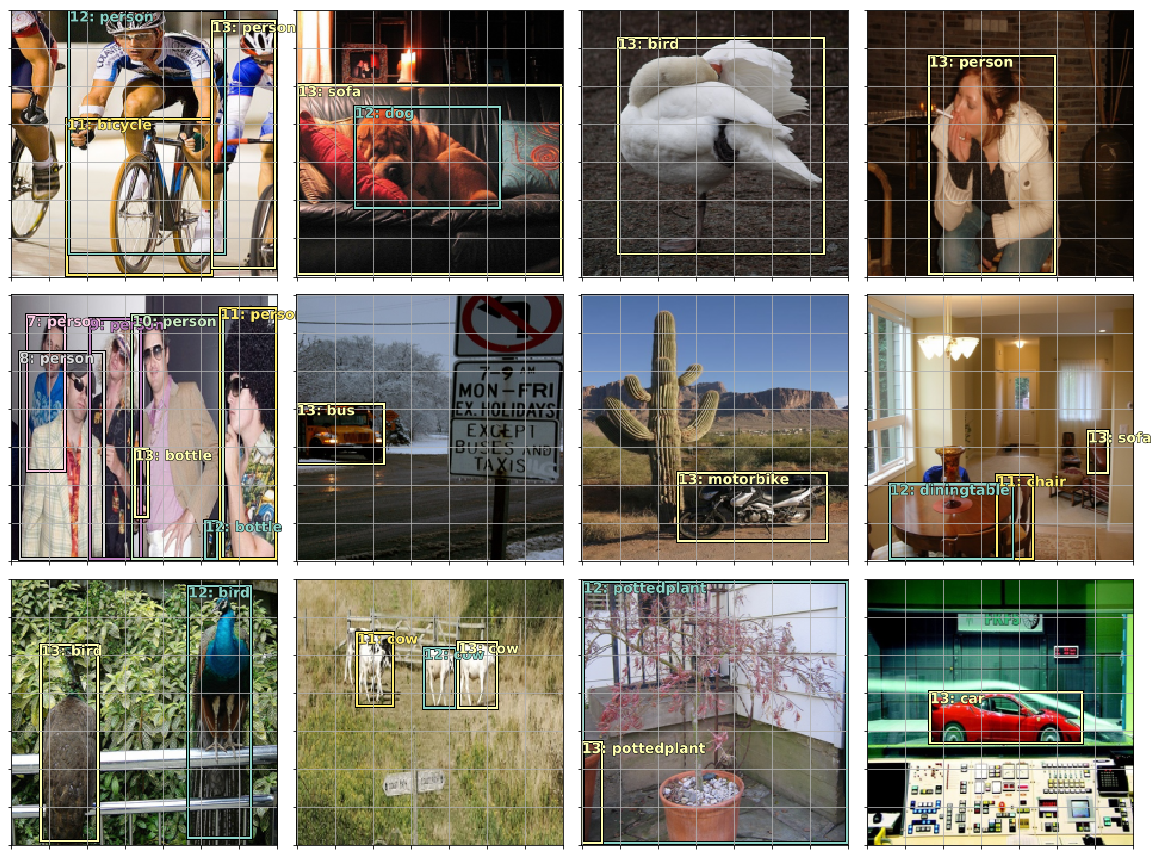

In [55]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

## Model

In [66]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [67]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

(0, 1)

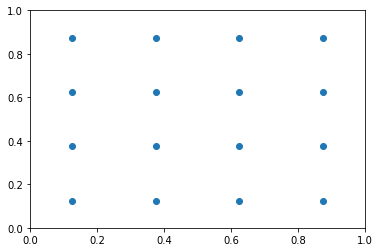

In [71]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [72]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [73]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [74]:
n_clas = len(id2cat)+1
n_act = k*(4+n_clas)

In [80]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
    
    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [83]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [103]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512, 256, stride=1)
        self.sconv2 = StdConv(256, 256, stride=2)
        self.out = OutConv(k, 256, bias)
    
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv2(x)
        return self.out(x)
        
head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [104]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [105]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [106]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [107]:
x,y = next(iter(md.val_dl))
# x,y = V(x).cpu(),V(y)
x,y = V(x),V(y)

In [108]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

In [109]:
learn.lr_find(lrs/1000, 1.)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      108.073373 5939.265625



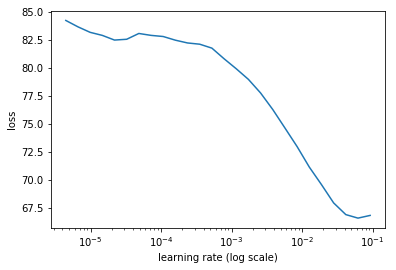

In [110]:
learn.sched.plot(1)

In [118]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      25.123503  30.365089 
    1      24.63558   28.259937                           
    2      23.160098  26.475685                           
    3      21.479959  25.962379                           
    4      19.972423  25.638016                           



[25.638016]

## Testing

In [122]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x)
b_clas,b_bb = batch

In [123]:
b_clas.size(),b_bb.size()

(torch.Size([64, 16, 21]), torch.Size([64, 16, 4]))

In [124]:
idx=7
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clasoverlaps.max(1)

(Variable containing:
  0.6786  0.4866  0.9911  0.6250
  0.7098  0.0848  0.9911  0.5491
  0.5134  0.8304  0.6696  0.9063
 [torch.cuda.FloatTensor of size 3x4 (GPU 0)], Variable containing:
   8
  10
  17
 [torch.cuda.LongTensor of size 3 (GPU 0)])

In [125]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

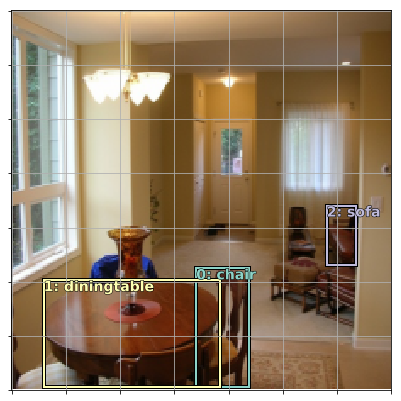

In [126]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

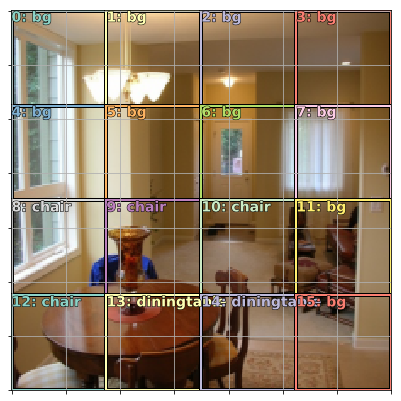

In [127]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

In [128]:
grid_sizes

Variable containing:
 0.2500
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

In [129]:
a_ic = actn_to_bb(b_bboxi, anchors)

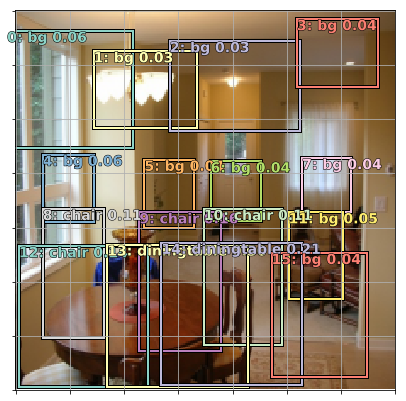

In [130]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)

In [131]:
overlaps = jaccard(bbox.data, anchor_cnr.data)
overlaps



Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0091
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0356  0.0549
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 10 to 15 
 0.0922  0.0000  0.0000  0.0315  0.3985  0.0000
 0.0103  0.0000  0.2598  0.4538  0.0653  0.0000
 0.0000  0.1897  0.0000  0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 3x16 (GPU 0)]

In [132]:
overlaps.max(1)

(
  0.3985
  0.4538
  0.1897
 [torch.cuda.FloatTensor of size 3 (GPU 0)], 
  14
  13
  11
 [torch.cuda.LongTensor of size 3 (GPU 0)])

In [133]:
gt_overlap,gt_idx = map_to_ground_truth(overlaps)
gt_overlap,gt_idx

(
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0356
  0.0549
  0.0922
  1.9900
  0.2598
  1.9900
  1.9900
  0.0000
 [torch.cuda.FloatTensor of size 16 (GPU 0)], 
  0
  0
  0
  0
  0
  0
  0
  0
  1
  1
  0
  2
  1
  1
  0
  0
 [torch.cuda.LongTensor of size 16 (GPU 0)])

In [134]:
gt_clas = clas[gt_idx]; gt_clas

Variable containing:
  8
  8
  8
  8
  8
  8
  8
  8
 10
 10
  8
 17
 10
 10
  8
  8
[torch.cuda.LongTensor of size 16 (GPU 0)]

In [135]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(1-pos)[:,0]
pos_idx


 11
 13
 14
[torch.cuda.LongTensor of size 3 (GPU 0)]

In [136]:
gt_clas[1-pos] = len(id2cat)
[id2cat[o] if o<len(id2cat) else 'bg' for o in gt_clas.data]

['bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'sofa',
 'bg',
 'diningtable',
 'chair',
 'bg']